In [4]:
import torch
import torch.nn as nn
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
sys.path.append('..')

from model import BoxRec
from model import MatrixFactorization, MatrixFactorizationWithBias
from data_loaders.data_processing import DataProcessing, MovieLensDataProcessing


## Load model args and checkpoints

In [5]:
model_dir = '../checkpoints/ml-1m/mf_bias/dim_64-negs_5/20240326124055'

In [6]:
def load_model(model_dir):
    arg_dict = json.load(open(model_dir + '/args.json', 'r'))
    if arg_dict['model'] == 'box':
        model = BoxRec(
                n_users=arg_dict['num_users'],
                n_items=arg_dict['num_items'],
                embedding_dim=arg_dict['embedding_dim'],
                volume_temp=arg_dict['volume_temp'],
                intersection_temp=arg_dict['intersection_temp']
        )
    elif arg_dict['model'] == 'mf_bias':
        model = MatrixFactorizationWithBias(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    elif arg_dict['model'] == 'mf':
        model = MatrixFactorization(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    else:
        raise ValueError('Invalid model type')
    model.load_state_dict(torch.load(model_dir + '/final_model.pth'))
    return model, arg_dict

In [7]:
# load the model
vector_model, arg_dict = load_model(model_dir)

## Calculate Marginal Probabilities from the data

In [8]:
def get_dataset_statistics(dataset):
    gt_dict = dataset.get_gt_dict(dataset.gt_df)
    item2user = {}
    total_count = 0
    for user, items in gt_dict.items():
        total_count += len(items)
        for item in items:
            if item not in item2user:
                item2user[item] = []
            item2user[item].append(user)
    
    marginal_prob_movies = {}
    for item, users in item2user.items():
        marginal_prob_movies[item] = len(users) / total_count

    marginal_prob_users = {}
    for user, items in gt_dict.items():
        marginal_prob_users[user] = len(items) / total_count
    
    total_prob = 0
    for movie, prob in marginal_prob_movies.items():
        total_prob += prob
    assert np.allclose(total_prob, 1.0)

    total_prob = 0
    for user, prob in marginal_prob_users.items():
        total_prob += prob
    assert np.allclose(total_prob, 1.0)
    
    return marginal_prob_movies, marginal_prob_users
        


In [9]:
dataset = MovieLensDataProcessing(data_dir='../' + arg_dict['data_dir'],
                                        dataset_type=arg_dict['dataset'],
                                        batch_size=arg_dict['batch_size'])
user2id = dataset.user2id
item2id = dataset.item2id
marginal_prob_movies, marginal_prob_users = get_dataset_statistics(dataset)

Data files read successfully...
ID files read successfully...


### Computing log Probabilites

In [10]:
item_probs = np.log(list(marginal_prob_movies.values()))
user_probs = np.log(list(marginal_prob_users.values()))

## Calculate User and Item volumes from the Embeddings

In [11]:
def get_model_statistics(model, marginal_prob_movies, marginal_prob_users, arg_dict):
    all_items = torch.tensor(list(marginal_prob_movies.keys()))
    all_users = torch.tensor(list(marginal_prob_users.keys()))
    all_items_emb = model.item_embeddings(all_items)
    all_users_emb = model.user_embeddings(all_users)
    if arg_dict['model'] == 'box':
        item_volume = all_items_emb._log_soft_volume_adjusted(
                                                all_items_emb.z,
                                                all_items_emb.Z,
                                                volume_temp=arg_dict['volume_temp'],
                                                intersection_temp=arg_dict['intersection_temp']).tolist()
        user_volume = all_users_emb._log_soft_volume_adjusted(
                                                    all_users_emb.z,
                                                    all_users_emb.Z,
                                                    volume_temp=arg_dict['volume_temp'],
                                                    intersection_temp=arg_dict['intersection_temp']).tolist()
    else:
        # norm of the vectors
        item_volume = torch.norm(all_items_emb, dim=1).tolist()
        user_volume = torch.norm(all_users_emb, dim=1).tolist()
    return item_volume, user_volume


In [12]:
item_volume, user_volume = get_model_statistics(vector_model, marginal_prob_movies, marginal_prob_users, arg_dict)

## Item Marginal Prob vs Embedding Volume correlation

In [13]:
def plot_correlation(x, y, xlabel, ylabel, title):
    plt.scatter(x, y, alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

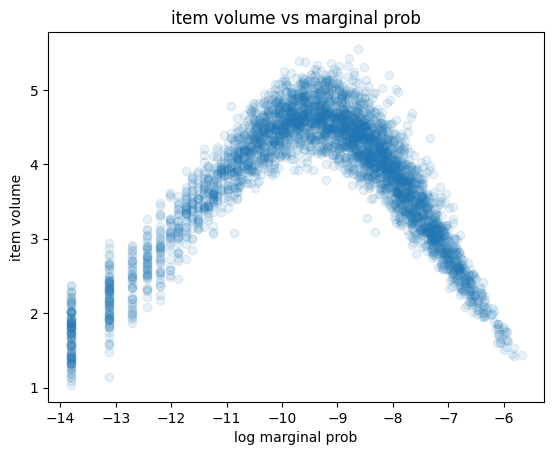

In [14]:
plot_correlation(item_probs, item_volume, 'log marginal prob', 'item volume', 'item volume vs marginal prob')

## User Marginal Probability vs Embedding volume correlation

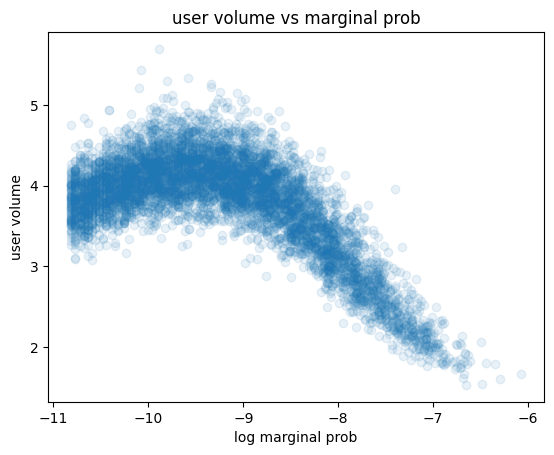

In [15]:
plot_correlation(user_probs, user_volume, 'log marginal prob', 'user volume', 'user volume vs marginal prob')

In [20]:
model_dir = '../checkpoints/ml-1m/box/dim_64-negs_5/20240325182359/'
box_model, arg_dict_box = load_model(model_dir)
item_volume_box, user_volume_box = get_model_statistics(box_model, marginal_prob_movies, marginal_prob_users, arg_dict_box)

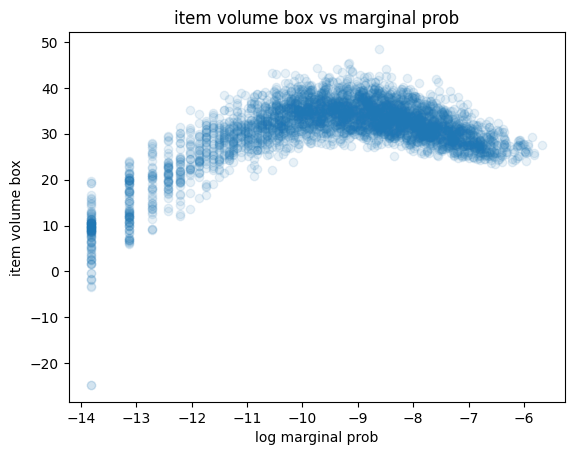

In [21]:
plot_correlation(item_probs, item_volume_box, 'log marginal prob', 'item volume box', 'item volume box vs marginal prob')

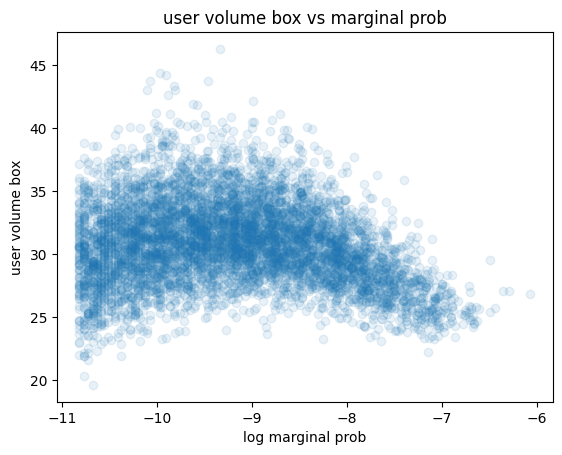

In [22]:
plot_correlation(user_probs, user_volume_box, 'log marginal prob', 'user volume box', 'user volume box vs marginal prob')